In [1]:
%who

Interactive namespace is empty.


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
from statsmodels.formula.api import glm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import itertools
import datetime
from dask.distributed import Client, LocalCluster
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
import time
import glob
from statsmodels.tools.sm_exceptions import PerfectSeparationError

def create_filepath_oneTime(ds, prefix='filename', root_path="."):
    """
    Generate a filepath when given an xarray dataset
    """
    time_str = ds.time.dt.strftime("%Y-%m-%d").data
    filepath = f'{root_path}/{prefix}_{time_str}.nc'
    return filepath

# define a function to fit the GLM model
def fit_logistReg_4Pred_oneThres(y, x1, x2, x3, x4, predictors, thres, formula, x1_new, x2_new, x3_new, x4_new, n_predictors = 5):
    '''Function to fit a logistic regression model to estimate exceedence probability
    using a thres argument. If the thres argument is nan, the grid is not in drought.
    '''
    GLM_params = np.empty(n_predictors)
    GLM_pvalues = np.empty(n_predictors)
    GLM_probability = np.empty(1)
    GLM_aic = np.empty(1)

    if np.isnan(thres):
        GLM_probability[:] = np.nan
        GLM_params[:] = np.nan
        GLM_pvalues[:] = np.nan
        GLM_aic[:] = np.nan
    else:
        y_binary = np.where(y >= thres, 1, 0)      
        if (sum(y_binary) < 4):                      # too few data points for estimation
            GLM_probability[:] = 0
            GLM_params[:] = 0
            GLM_pvalues[:] = np.nan
            GLM_aic[:] = np.nan
        else:                                        # logistic regression fit
            # create a dataframe of reponse and predictors
            x_dict = {predictors[0]:x1, predictors[1]:x2, predictors[2]:x3, predictors[3]:x4}
            x = pd.DataFrame(x_dict)
            x['response'] = y_binary

            x_new_dict = {predictors[0]:x1_new, predictors[1]:x2_new, predictors[2]:x3_new, predictors[3]:x4_new}
            x_new = pd.DataFrame(x_new_dict, index = [0])

            model = glm(formula, x, family=sm.families.Binomial())
            try:
                model_GLM = model.fit()
                GLM_probability[:] = model_GLM.predict(x_new)
                GLM_params[:] = model_GLM.params.values
                GLM_pvalues[:] = model_GLM.pvalues.values
                GLM_aic[:] = model_GLM.aic
            except PerfectSeparationError:          # this error occurs at longer timescales with fewer data points
                GLM_probability[:] = np.nan
                GLM_params[:] = np.nan
                GLM_pvalues[:] = np.nan
                GLM_aic[:] = np.nan
    return GLM_params, GLM_pvalues, GLM_probability, GLM_aic

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [24]:
main_dir = '/g/data/w97/ad9701/p_prob_analysis/temp_files/'

varname = 'PminusEQ' #'P'   # the name of the directory and file
vname = 'PminusEQ'   #'precip'  # the name of the variable inside the files
fname = varname + '_*_*_*.nc'

iW = 12 #int(os.environ['iWeek'])
print(iW)
start_yr = 1911 #int(os.environ['start_yr'])
end_yr = start_yr #int(os.environ['end_yr'])
sub_dir = ''

# select thresholds
# load the threshold data file & select the drought period of interest
PmEQ_events_file = 'sm_droughts/PmEQ_events_*.nc'
ds_thresh = xr.open_mfdataset(main_dir + PmEQ_events_file)
drght_time_slice = slice(str(start_yr)+'-01-01', str(end_yr)+'-12-31')
drght_name = 'full_record'
drght_dir = 'GLM_results_model2_' + drght_name

# select the thresholds for the time periods of the drought
thresName = 'PminusEQ'
da_thresh = ds_thresh[thresName].sel(time = drght_time_slice)

############################################
# GET THE SST PREDICTORS
############################################

# get the sst data
sst_dir = '/g/data/w97/ad9701/p_prob_analysis/sst_data/'
pNames = ['soi', 'sami', 'dmi', 'nino34_anom', 'nino4_anom']
pFiles = ['soi_monthly.nc', 'newsam.1957.2021.nc', 'dmi.had.long.data.nc', 'nino34.long.anom.data.nc', 'nino4.long.anom.data.nc']
for p in np.arange(len(pNames)):
    ds_temp = xr.open_dataset(sst_dir+pFiles[p])
    if (p>0):
        ds_p[pNames[p]]=ds_temp[pNames[p]]
    else:
        ds_p = ds_temp
    del ds_temp

# select the predictors to include in the model
predSel = ['soipos', 'soineg', 'dmipos', 'dmineg']
formula = 'response ~ soipos + soineg + dmipos + dmineg'
parameter = ['Intercept']
parameter.extend(predSel)

# select the sst predictors corresponding to the dates of the thresholds data
thresh_time_bymon = np.array(pd.to_datetime(da_thresh.time).to_period('M').to_timestamp().floor('D'))
da_p1_current = ds_p['soi'].where(ds_p['soi']>=0, other=0).sel(time = thresh_time_bymon)
da_p2_current = ds_p['soi'].where(ds_p['soi']<0, other=0).sel(time = thresh_time_bymon)
da_p3_current = ds_p['dmi'].where(ds_p['dmi']>=0, other=0).sel(time = thresh_time_bymon)
da_p4_current = ds_p['dmi'].where(ds_p['dmi']<0, other=0).sel(time = thresh_time_bymon)

12


In [25]:
############################################
# START A LOCAL CLUSTER
############################################

# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
# client = Client(cluster)
# client

############################################
# PERFORM CALCULATIONS FOR THE MAIN SET
############################################

# get data
data_dir = main_dir + varname + '_week' + str(iW) + '/' + sub_dir + '/'
print(data_dir)
ds = xr.open_mfdataset(data_dir + fname, chunks = {'lat':400, 'lon':400})
da_var_temp = ds[vname].reindex(lat=ds.lat[::-1]).chunk(chunks = {'lat':40,'lon':40,'time':-1}).rename({'time':'hist_time'})
da_var = da_var_temp.groupby('hist_time.season')

# select predictors for the same time points as the P-E or P-E-Q data at multi-weekly timescale
da_time_bymon = np.array(pd.to_datetime(ds.time).to_period('M').to_timestamp().floor('D'))
ds_p_sel = ds_p.sel(time = da_time_bymon)
ds_p1_sel_gb = ds_p_sel['soi'].where(ds_p_sel['soi']>=0, other=0).rename({'time':'hist_time'}).groupby('hist_time.season')
ds_p2_sel_gb = ds_p_sel['soi'].where(ds_p_sel['soi']<0, other=0).rename({'time':'hist_time'}).groupby('hist_time.season')
ds_p3_sel_gb = ds_p_sel['dmi'].where(ds_p_sel['dmi']>=0, other=0).rename({'time':'hist_time'}).groupby('hist_time.season')
ds_p4_sel_gb = ds_p_sel['dmi'].where(ds_p_sel['dmi']<0, other=0).rename({'time':'hist_time'}).groupby('hist_time.season')

full_dir_path = main_dir + '/' + drght_dir + '/' + varname + '_week' + str(iW) + '/' + sub_dir + '/by_day/'
if not os.path.exists(full_dir_path):
    os.makedirs(full_dir_path)

/g/data/w97/ad9701/p_prob_analysis/temp_files/PminusEQ_week12//


In [27]:
start_day = 0
dask_gufunc_kwargs = {'output_sizes':{"glm_parameter": len(parameter)}} #, 'time':1}}

# looping over the current times
for i_time in [0]: #range(start_day, len(da_thresh.time)):
    seas = da_thresh['time.season'].values[i_time]
    da_logistReg = xr.apply_ufunc(
        fit_logistReg_4Pred_oneThres,                # first the function, this function returns a tuple (GLM params, GLM pvalues, GLM modelled probabilities)
        da_var[seas],                                # function arg
        ds_p1_sel_gb[seas].values,
        ds_p2_sel_gb[seas].values,
        ds_p3_sel_gb[seas].values,
        ds_p4_sel_gb[seas].values,
        predSel,                                     #      "
        da_thresh.sel(timescale = iW).isel(time = i_time),                                  #      "
        formula,                                     #      "
        [da_p1_current.values[i_time]],                    #      "
        [da_p2_current.values[i_time]], #      "
        [da_p3_current.values[i_time]],
        [da_p4_current.values[i_time]],
        input_core_dims=[["hist_time"], ["hist_time"], ["hist_time"], ["hist_time"], ["hist_time"], ["predictors"], [], [], [], [], [], []], #["sample_time"], ["sample_time"]],   # list with one entry per arg, these are the dimensions not to be broadcast
        output_core_dims=[["glm_parameter"], ["glm_parameter"], [], []],                                # dimensions of the output
        vectorize=True,                                                                                                                    # broadcast over non-core dimensions of the input object?
        dask="parallelized",                                                                                                               # enable dask?
        dask_gufunc_kwargs=dask_gufunc_kwargs,                     
        output_dtypes=[float, float, float, float]
    )

    # assign co-ordinates add metadata
    new_coords_dict = {'glm_parameter':parameter} #, 'current_time':[da_thresh['current_time'][i_time]]}    
    ds_all = da_logistReg[2].rename('glm_probability').to_dataset()
    ds_all['glm_params'] = da_logistReg[0].rename('glm_params').assign_coords(new_coords_dict)
    ds_all['glm_pvalues'] = da_logistReg[1].rename('glm_pvalues').assign_coords(new_coords_dict)
    ds_all['glm_aic'] = da_logistReg[3].rename('glm_aic')
    ds_all[predSel[0]] = da_p1_current.isel(time = i_time)
    ds_all[predSel[1]] = da_p2_current.isel(time = i_time)
    ds_all[predSel[2]] = da_p3_current.isel(time = i_time)
    ds_all[predSel[3]] = da_p4_current.isel(time = i_time)

    out_file = create_filepath_oneTime(ds_all, prefix = 'GLM_results_' + '_'.join(predSel), root_path = full_dir_path)
    # ds_all.to_netcdf(out_file)

In [28]:
ds_all.to_netcdf(out_file)

In [26]:
lat = -33.5 #lati = 70
lon = 145 #loni = 130
i_time = 100

seas = da_thresh['time.season'].values[i_time]
da_var_pt = da_var[seas].sel(lat = lat, lon = lon)
p1 = ds_p1_sel_gb[seas].values
p2 = ds_p2_sel_gb[seas].values
p3 = ds_p3_sel_gb[seas].values
p4 = ds_p4_sel_gb[seas].values
da_var_pt_thresh = da_thresh.sel(timescale = iW).isel(time = i_time).sel(lat = lat, lon = lon)
p1_new = da_p1_current.values[i_time]
p2_new = da_p2_current.values[i_time]
p3_new = da_p3_current.values[i_time]
p4_new = da_p4_current.values[i_time]

fit_logistReg_4Pred_oneThres(y=da_var_pt.values, x1=p1, x2=p2, x3=p3, x4=p4, 
                             predictors=predSel, thres=da_var_pt_thresh.values, formula=formula, x1_new=p1_new, x2_new=p2_new, x3_new=p3_new, x4_new=p4_new)

(array([-0.09893129,  0.06633036, -0.13249881, -0.07079346, -0.08330972]),
 array([0.81307102, 0.10655953, 0.01267888, 0.97045527, 0.95439429]),
 array([0.52233022]),
 array([154.62293216]))

In [21]:
p4_new

-0.668

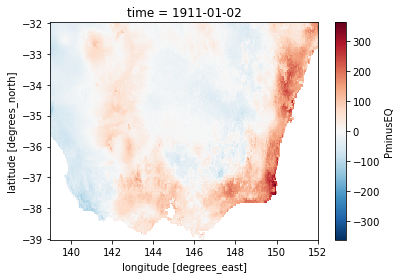

In [7]:
ds['PminusEQ'][0,:,:].plot()

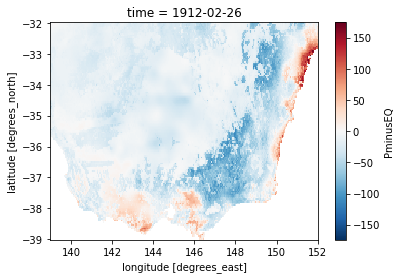

In [49]:
ds['PminusEQ'][5,:,:].plot()

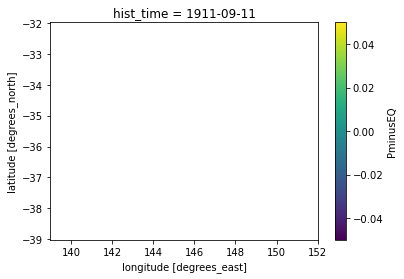

In [40]:
da_var_temp[3,:,:].plot()

array(3.25293613)

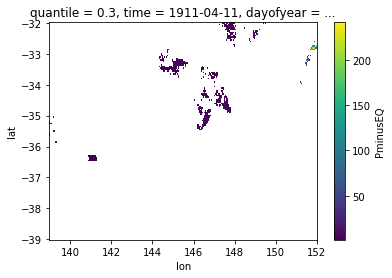

In [22]:
i_time = 100
da_thresh.sel(timescale = iW).isel(time = i_time).plot()
da_thresh.sel(timescale = iW).isel(time = i_time).sel(lat = -33.5, lon = 145).values

In [28]:
ds_all

<xarray.Dataset>
Dimensions:          (lat: 141, lon: 261, glm_parameter: 5)
Coordinates:
  * lat              (lat) float32 -32.0 -32.05 -32.1 ... -38.9 -38.95 -39.0
  * lon              (lon) float32 139.0 139.1 139.1 139.1 ... 151.9 151.9 152.0
    quantile         float64 0.3
    time             datetime64[ns] 1911-01-01
    dayofyear        int64 dask.array<chunksize=(), meta=np.ndarray>
    parameter        <U4 'PmEQ'
    timescale        int64 12
  * glm_parameter    (glm_parameter) <U9 'Intercept' 'soipos' ... 'dmineg'
Data variables:
    glm_probability  (lat, lon) float64 dask.array<chunksize=(40, 40), meta=np.ndarray>
    glm_params       (lat, lon, glm_parameter) float64 dask.array<chunksize=(40, 40, 5), meta=np.ndarray>
    glm_pvalues      (lat, lon, glm_parameter) float64 dask.array<chunksize=(40, 40, 5), meta=np.ndarray>
    glm_aic          (lat, lon) float64 dask.array<chunksize=(40, 40), meta=np.ndarray>
    soipos           float64 3.2
    soineg           float64 nan
    dmipos           float64 nan
    dmineg           float64 -0.129